In [ ]:
# pip install --upgrade jupyter_http_over_ws>=0.0.7 && jupyter serverextension enable --py jupyter_http_over_ws
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8899 --NotebookApp.port_retries=0
# https://www.data-in.ru/data-catalog/datasets/186/ # 01.01.2018 — 30.10.2021
# https://trudvsem.ru/opendata/datasets # 03.11.2022, 01.02.23

In [ ]:
import pandas as pd
import pickle, os
import numpy as np
import datetime as dt
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns, re
from zipfile import ZipFile as zp
from scipy.stats import kurtosis

In [ ]:
base_dir = './'
#_dataset_date = '03.11.2022'
_dataset_date = '29.12.2022'
#_dataset_date = '08.08.2023'
_start_from_date = '2019-01-01'
_keep_cols = ['id', 'state_region_code', 'id_candidate', 'date_create', 'date_modify', 'published_date',
              'education', 'academic_degree', 'experience', 'salary', 'professional_skills', 'desirableRelocationRegions', 'busy_type', 'business_trip', 'languageKnowledge']

In [ ]:
d = pd.read_csv(os.path.join(base_dir, f'cv_raw_{_dataset_date}.csv'), sep='|', dtype='str', nrows=10, on_bad_lines=None)
COLSEPNUM = len(d.columns.to_list()) - 1
print(f'{_dataset_date} columns count: {COLSEPNUM}')

29.12.2022 columns count: 43


In [ ]:
d.columns

Index(['id', 'abilympics_inspection_status', 'abilympics_participation',
       'worldskills_inspection_status', 'state_region_code', 'regionNameTerm',
       'position_name', 'date_create', 'date_modify', 'home_city_code',
       'education', 'academic_degree', 'drive_license', 'code_country',
       'nark_inspection_status', 'nark_certificate', 'published_date',
       'schedule_type', 'experience', 'salary', 'professional_skills',
       'add_skills', 'busy_type', 'business_trip', 'id_candidate',
       'other_certificates', 'retraining_capability', 'other_info', 'id_user',
       'publication_period', 'rf_citizen', 'status', 'visibility',
       'code_external_system', 'deleted', 'fullness_rate', 'professionList',
       'workExperienceList', 'educationList', 'additionalEducationList',
       'desirableRelocationRegions', 'contactList', 'worldskills',
       'languageKnowledge'],
      dtype='object')

### fix

In [ ]:
def fix_dashes(s):
    nbs = r'(\[[^\[\]]+\])'
    pattern = re.compile(nbs)
    s = s.replace(r'|</p>', '</p>')
    s = s.replace(r'|&nbsp;', '&nbsp;')
    s = s.replace(r'Htm|', 'HTML')
    for m in pattern.finditer(s):
      s = s[:m.start()]+s[m.start():m.end()].replace('|', ' ')+s[m.end():]
    if s.count('|') != COLSEPNUM:
      s = s.replace(r'-|-', '-')
#    if s.count('|') != COLSEPNUM:
#      s = '|'*43
    return s

def fix_data(date):
  bad_lines_count = 0
  counter = 0
  with open(os.path.join(base_dir, f'cv_raw_{date}_fixed.csv'), 'wt', encoding='utf-8') as f0:
    with open(os.path.join(base_dir, f'cv_raw_{date}_bad.csv'), 'wt', encoding='utf-8') as f2:
      with open(os.path.join(base_dir, f'cv_raw_{date}.csv'), 'rt', encoding='utf-8') as f1:
        for raw in tqdm(f1):
          counter += 1
          c_raw = raw.count('|')
          if c_raw == COLSEPNUM:
            f0.write(raw)
          else:
            fix = fix_dashes(raw)
            c_fix = fix.count('|')
            if c_fix == COLSEPNUM:
              f0.write(fix)
            else:
              bad_lines_count += 1
              f2.write(raw)
  print(f'lines: {counter}, bad lines rate: {bad_lines_count / counter}')

In [ ]:
fix_data(_dataset_date)

1240600it [01:37, 12741.22it/s]

lines: 1240600, bad lines rate: 8.544252780912461e-05


### tudy

In [ ]:
def localize(x):
  try:
    return pd.to_datetime(x).tz_localize(None)
  except:
    return np.nan

def truncate_data(date):
    df = None
    r = pd.read_csv(os.path.join(base_dir, f'regions.csv'), sep=';', dtype='str')
    chunksize = 10 ** 6
    with pd.read_csv(os.path.join(base_dir, f'cv_raw_{date}_fixed.csv'), sep='|', dtype='str', chunksize=chunksize) as reader:
        for chunk in tqdm(reader):
            chunk['date_create'] = chunk['date_create'].apply(localize)
            chunk = chunk[chunk['date_create'].apply(lambda x: x >= pd.to_datetime(_start_from_date).tz_localize(None) if pd.notna(x) else False)]
            chunk = chunk[_keep_cols]\
                    .rename(columns={'state_region_code' : 'region_code'})\
                    .merge(r[['region_code', 'region_name']], how='left', on='region_code')
            chunk['date_modify'] = chunk['date_modify'].apply(localize)
            chunk['published_date'] = chunk['published_date'].apply(localize)
            df = pd.concat([df, chunk])
            # break
    df.to_csv(os.path.join(base_dir, f'cv_raw_{date}_truncated.csv'), sep=';', index=False)
    with open(os.path.join(base_dir, f'cv_raw_{date}_truncated.pickle'), 'wb') as pf:
        pickle.dump(df, pf, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'date: {date}, count: {len(df)}')
    return df

In [ ]:
df = truncate_data(_dataset_date)

2it [19:15, 577.64s/it]


date: 03.11.2022, count: 1120811


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120811 entries, 0 to 217583
Data columns (total 16 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   id                          1120811 non-null  object        
 1   region_code                 1120800 non-null  object        
 2   id_candidate                1120811 non-null  object        
 3   date_create                 1120811 non-null  datetime64[ns]
 4   date_modify                 1120811 non-null  datetime64[ns]
 5   published_date              1120811 non-null  datetime64[ns]
 6   education                   816400 non-null   object        
 7   academic_degree             1444 non-null     object        
 8   experience                  714224 non-null   object        
 9   salary                      1120811 non-null  object        
 10  professional_skills         180032 non-null   object        
 11  desirableRelocationRegion

In [ ]:
df.head(3)

,id,region_code,id_candidate,date_create,date_modify,published_date,education,academic_degree,experience,salary,professional_skills,desirableRelocationRegions,busy_type,business_trip,languageKnowledge,region_name
0,fb270bd0-1a65-11e9-95e0-ef76bd2a03c1,2300000000000,b904cc00-1a61-11e9-95e0-ef76bd2a03c1,2019-01-17 17:41:31,2022-07-08 10:02:44,2019-01-18 07:54:20,Высшее,NaN,22,40000,"<p>Грамотный, дисциплинированный, исполнительн...",[],Полная занятость,Готов к командировкам,"[{""code_language"":""Английский"",""level"":""Чтение...",Краснодарский край
1,e664f940-869c-11ec-a2e7-839f0d9a4379,3600000000000,a5ff3030-85cc-11ec-9d07-d768660431c4,2022-02-05 19:01:38,2022-02-21 10:03:13,2022-02-21 10:03:13,Среднее профессиональное,NaN,0,20000,NaN,[],Полная занятость,NaN,[],Воронежская область
2,21fecfd0-01d6-11ed-9021-839f0d9a4379,6700000000000,b72bdb80-01d5-11ed-9497-f557cda0de1e,2022-07-12 14:31:12,2022-08-05 21:10:12,2022-07-12 14:32:00,NaN,NaN,NaN,15279,NaN,[],Временная,NaN,"[{""code_language"":""Русский"",""level"":""Родной"",""...",Смоленская область


### join

In [ ]:
_dataset_date = '29.12.2022'
with open(os.path.join(base_dir, f'cv_raw_{_dataset_date}_truncated.pickle'), 'rb') as pf:
    df_291222 = pickle.load(pf)
print(len(df_291222))
_dataset_date = '08.08.2023'
with open(os.path.join(base_dir, f'cv_raw_{_dataset_date}_truncated.pickle'), 'rb') as pf:
    df_080823 = pickle.load(pf)
print(len(df_080823))

3784341

In [ ]:
df = pd.concat([df_080823, df_291222], ignore_index=True).drop_duplicates(['id'])
with open(os.path.join(base_dir, f'cv_raw_truncated.pickle'), 'wb') as pf:
        pickle.dump(df, pf, protocol=pickle.HIGHEST_PROTOCOL)
        print(f'count: {len(df)}')

count: 7595113


### before

In [ ]:
base_dir = './'
before_date = '03.11.2022'
after_date = '01.02.2023'

In [ ]:
with open(os.path.join(base_dir, f'cv_raw_{before_date}_truncated.pickle'), 'rb') as pf:
    df = pickle.load(pf)
len(df)

472015

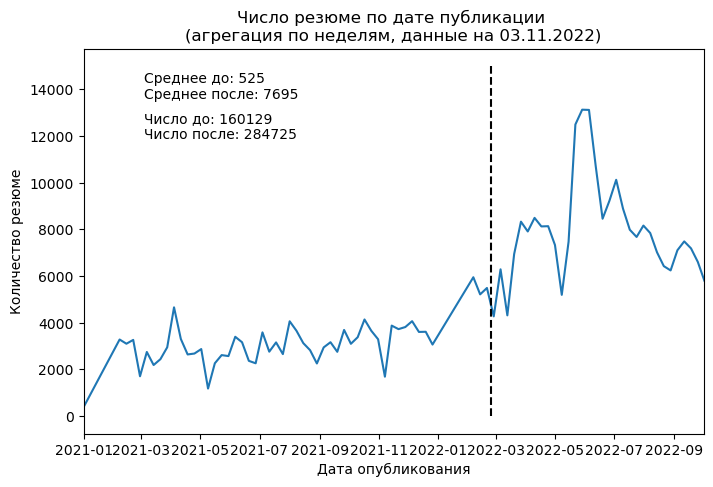

In [ ]:
cv = df.set_index('published_date').resample('W').count().reset_index()

cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
cv = cv[cv['publish_month'] != '01']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(cv['published_date'], cv['id'])
ax.vlines(dt.datetime(2022, 2, 24), 0, 1.5e4, colors='k', linestyles='--')
ax.set_xlim(['2021-01-01', '2022-10-01'])
_before = cv[cv['published_date'] < '2022-02-24']['id']
_after = cv[cv['published_date'] >= '2022-02-24']['id']
fig.text(0.2, 0.78, f"Среднее до: {int(_before.mean())}\nСреднее после: {int(_after.mean())}", ha='left')
fig.text(0.2, 0.70, f"Число до: {_before.sum()}\nЧисло после: {_after.sum()}", ha='left')
plt.title(f'Число резюме по дате публикации \n(агрегация по неделям, данные на {before_date})')
plt.xlabel('Дата опубликования')
plt.ylabel('Количество резюме')
plt.show()

In [ ]:
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
#cv = cv[cv['publish_month'] != '01']

def _agg(g):
    return np.mean(g.set_index('published_date').resample('W').count()['id'])

cv_mean_count_diff = None
for idx, g in cv.groupby(['region_code']):
    region_code = np.min(g.region_code)
    _before = g[g['published_date'] < '2022-02-24'][['id', 'published_date', 'region_code']]
    _after = g[g['published_date'] >= '2022-02-24'][['id', 'published_date', 'region_code']]
    _diff = _agg(_after) - _agg(_before)
    cv_mean_count_diff = pd.concat([cv_mean_count_diff,
                  pd.DataFrame.from_dict({'region_code' : region_code, 'cv_mean_count_diff' : _diff}, orient='index').T])
cv_mean_count_diff2022 = cv_mean_count_diff.rename(columns={'cv_mean_count_diff' : 'cv_mean_count_diff2022'}).reset_index(drop=True)

In [ ]:
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
cv = cv[cv['publish_month'] == '02']

def _agg(g):
    return np.mean(g.set_index('published_date').resample('W').count()['id'])

cv_mean_count_diff = None
for idx, g in cv.groupby(['region_code']):
    region_code = np.min(g.region_code)
    _before = g[g['published_date'] < '2022-02-01'][['id', 'published_date', 'region_code']]
    _after = g[g['published_date'] >= '2022-02-01'][['id', 'published_date', 'region_code']]
    _diff = _agg(_after) / _agg(_before)
    cv_mean_count_diff = pd.concat([cv_mean_count_diff,
                  pd.DataFrame.from_dict({'region_code' : region_code, 'cv_mean_count_diff' : _diff}, orient='index').T])
cv_mean_count_difffeb = cv_mean_count_diff.rename(columns={'cv_mean_count_diff' : 'cv_mean_count_difffeb'}).reset_index(drop=True)

In [ ]:
# расчёт эксцесса с 2021-01-01
cv = df.groupby('region_name').resample('W', on='published_date').count()[['id']].reset_index()

cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
cv = cv[cv['publish_month'] != '01']

k = {}
for idx, g in cv.groupby('region_name'):
    k[idx] = kurtosis(g['id'], fisher=True)
excess_value = pd.Series(k).sort_values()
excess_binary = excess_value < 0.5
selected_regions = excess_value[excess_binary].index.to_list()

In [ ]:
pd.concat([excess_value, excess_binary], axis=1)\
          .reset_index()\
          .rename(columns={0:'excess_value', 1:'excess_binary', 'index':'region_name'})\
          .to_csv(os.path.join(base_dir, f'cv_excess_{before_date}.csv'), sep=';', index=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 15))
ax.barh(y=[i for i, _ in enumerate(excess_value)], width=[i for i in excess_value])
#ax.set_yticklabels(k.index.to_list())
ax.bar_label(ax.containers[0], labels=excess_value.index.to_list(), label_type='edge')

In [ ]:
# отобранные регионы по величине эксцесса
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[:8]+'01')
cv = cv.drop_duplicates(['id']).groupby(['region_name', 'publish_month']).count().reset_index()
cv = cv[cv['region_name'].apply(lambda x: x in selected_regions)]
fig = px.line(data_frame=cv, x="publish_month", y="id", color='region_name', render_mode='webgl',
              title=f'Число резюме по дате публикации \n(агрегация по месяцам, данные на {before_date})')
fig.add_vline(x="2022-02-24", line_width=3, line_dash="dash", line_color="green")
fig.show()

### after

In [ ]:
base_dir = './'
before_date = '03.11.2022'
after_date = '01.02.2023'

In [ ]:
with open(os.path.join(base_dir, f'cv_raw_{after_date}_truncated.pickle'), 'rb') as pf:
    df = pickle.load(pf)
len(df)

503853

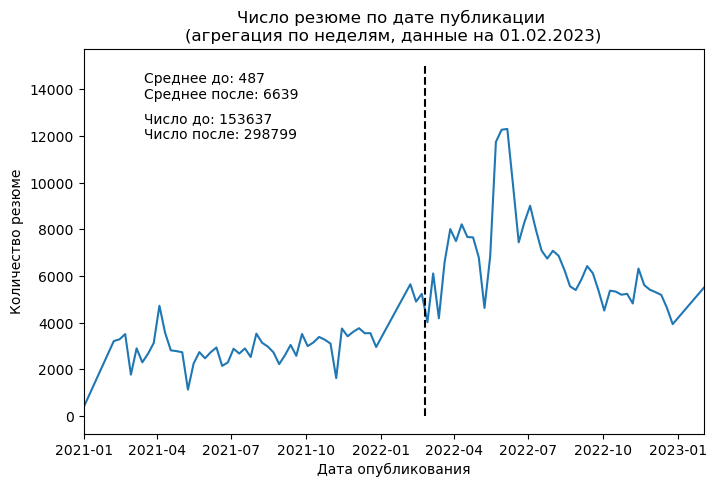

In [ ]:
cv = df.set_index('published_date').resample('W').count().reset_index()

cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
cv = cv[cv['publish_month'] != '01']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(cv['published_date'], cv['id'])
ax.vlines(dt.datetime(2022, 2, 24), 0, 1.5e4, colors='k', linestyles='--')
ax.set_xlim(['2021-01-01', '2023-02-01'])
_before = cv[cv['published_date'] < '2022-02-24']['id']
_after = cv[cv['published_date'] >= '2022-02-24']['id']
fig.text(0.2, 0.78, f"Среднее до: {int(_before.mean())}\nСреднее после: {int(_after.mean())}", ha='left')
fig.text(0.2, 0.70, f"Число до: {_before.sum()}\nЧисло после: {_after.sum()}", ha='left')
plt.title(f'Число резюме по дате публикации \n(агрегация по неделям, данные на {after_date})')
plt.xlabel('Дата опубликования')
plt.ylabel('Количество резюме')
plt.show()

In [ ]:
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
#cv = cv[cv['publish_month'] != '01']

def _agg(g):
    return np.mean(g.set_index('published_date').resample('W').count()['id'])

cv_mean_count_diff = None
for idx, g in cv.groupby(['region_code']):
    region_code = np.min(g.region_code)
    _before = g[g['published_date'] < '2022-02-24'][['id', 'published_date', 'region_code']]
    _after = g[g['published_date'] >= '2022-02-24'][['id', 'published_date', 'region_code']]
    _diff = _agg(_after) - _agg(_before)
    cv_mean_count_diff = pd.concat([cv_mean_count_diff,
                  pd.DataFrame.from_dict({'region_code' : region_code, 'cv_mean_count_diff' : _diff}, orient='index').T])
cv_mean_count_diff2023 = cv_mean_count_diff.rename(columns={'cv_mean_count_diff' : 'cv_mean_count_diff2023'}).reset_index(drop=True)

In [ ]:
# расчёт эксцесса с 2021-01-01
cv = df.groupby('region_name').resample('W', on='published_date').count()[['id']].reset_index()

cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
cv = cv[cv['publish_month'] != '01']

k = {}
for idx, g in cv.groupby('region_name'):
    k[idx] = kurtosis(g['id'], fisher=True)
excess_value = pd.Series(k).sort_values()
excess_binary = excess_value < 0.5
selected_regions = excess_value[excess_binary].index.to_list()

In [ ]:
pd.concat([excess_value, excess_binary], axis=1)\
          .reset_index()\
          .rename(columns={0:'excess_value', 1:'excess_binary', 'index':'region_name'})\
          .to_csv(os.path.join(base_dir, f'cv_excess_{after_date}.csv'), sep=';', index=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 15))
ax.barh(y=[i for i, _ in enumerate(excess_value)], width=[i for i in excess_value])
#ax.set_yticklabels(k.index.to_list())
ax.bar_label(ax.containers[0], labels=excess_value.index.to_list(), label_type='edge')

In [ ]:
# отобранные регионы по величине эксцесса
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[:8]+'01')
cv = cv.drop_duplicates(['id']).groupby(['region_name', 'publish_month']).count().reset_index()
cv = cv[cv['region_name'].apply(lambda x: x in selected_regions)]
fig = px.line(data_frame=cv, x="publish_month", y="id", color='region_name', render_mode='webgl',
              title=f'Число резюме по дате публикации \n(агрегация по месяцам, данные на {before_date})')
fig.add_vline(x="2022-02-24", line_width=3, line_dash="dash", line_color="green")
fig.show()

In [ ]:
#########

In [ ]:
cv_mean_count_diff2022.set_index('region_code')\
    .join(cv_mean_count_diff2023.set_index('region_code'), how='left')\
    .join(cv_mean_count_difffeb.set_index('region_code'), how='left')\
    .to_csv(os.path.join(base_dir, 'cv_mean_count_diff.csv'), index=True, sep=';')